# PROYECTO 2 - Árboles de Decisión

Edman Cota 19830

Edwin de León 22809

[Repositorio](https://github.com/EJGDLG/Proyecto2Nuevo)

## Parte 1: Carga de Datos y Preprocesamiento
### Objetivo:

- Cargar el dataset.
- Seleccionar solo las variables numéricas.
- Dividir los datos en entrenamiento y prueba usando el mismo conjunto de la entrega anterior.
- Normalizar los datos para mejorar el desempeño de los modelos.

In [1]:
# Cargar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Cargar dataset
df = pd.read_csv('train.csv')

# Seleccionar variables numéricas
numerical_cols = df.select_dtypes(include=['number']).columns

# Separar en X (características) y y (objetivo)
X = df[numerical_cols].drop(columns=["SalePrice"])
y = df["SalePrice"]

# División de datos (mismo conjunto de la entrega anterior)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalización de datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Análisis y Discusión
Por qué usar solo variables numéricas:
Evitamos problemas con datos categóricos sin transformar.
Algunas variables categóricas ya fueron analizadas en la entrega anterior.
### División de datos (80% entrenamiento - 20% prueba):
Mantener los mismos datos permite comparar el rendimiento con la Regresión Lineal de la entrega anterior.
### Uso de StandardScaler:
Normaliza las características para evitar que algunas variables dominen el modelo.

## Parte 2: Árbol de Regresión para Predecir el Precio
Objetivo:

Entrenar un Árbol de Decisión para predecir precios de viviendas.
Evaluar su rendimiento con métricas clave.

In [4]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Crear y entrenar un Árbol de Regresión
reg_tree = DecisionTreeRegressor(random_state=42)
reg_tree.fit(X_train_scaled, y_train)

# Hacer predicciones
y_pred_tree = reg_tree.predict(X_test_scaled)

# Evaluación del modelo
print("\nÁrbol de Regresión")
print("MAE:", mean_absolute_error(y_test, y_pred_tree))
print("MSE:", mean_squared_error(y_test, y_pred_tree))
print("R2:", r2_score(y_test, y_pred_tree))



Árbol de Regresión
MAE: 27701.948630136987
MSE: 1800132497.25
R2: 0.7653121329359801


## Análisis y Discusión
### ¿Qué tan bien funciona el Árbol de Regresión?
- MAE: Promedio de error absoluto (más bajo = mejor).
- MSE: Penaliza errores grandes (debe ser bajo).
- R²: Indica cuánto explica el modelo la variabilidad del precio (1 es perfecto, 0 significa que el modelo no explica nada).
### Posibles problemas:
Un árbol sin límite de profundidad puede sobreajustarse.
Si el R² es alto en entrenamiento pero bajo en prueba - el modelo es demasiado complejo y necesita poda.

## Parte 3: Ajuste de Profundidad del Árbol de Regresión
Objetivo:

Entrenar árboles con diferentes profundidades (3, 5, 10, sin límite).
Evaluar cuál profundidad funciona mejor.

In [5]:
depths = [3, 5, 10, None]
models = {}

for depth in depths:
    tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    tree.fit(X_train_scaled, y_train)
    y_pred = tree.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    print(f"\nProfundidad {depth} - R2: {r2}")
    models[depth] = (tree, r2)

# Seleccionar mejor modelo
best_depth = max(models, key=lambda k: models[k][1])
print(f"\nMejor profundidad: {best_depth}")


Profundidad 3 - R2: 0.7713968028196675

Profundidad 5 - R2: 0.7952387297701387

Profundidad 10 - R2: 0.8265358466654014

Profundidad None - R2: 0.7653121329359801

Mejor profundidad: 10


## Análisis y Discusión
Profundidades menores (3, 5) pueden generar subajuste:
No capturan suficiente información de los datos.
### Profundidades altas (10, None) pueden generar sobreajuste:
Memorizan los datos en lugar de generalizar.
### Conclusión:
Elegimos la profundidad con mejor R² en prueba, evitando sobreajuste.


## Parte 4: Comparación con Regresión Lineal
Objetivo:

Comparar el Árbol de Regresión vs. Regresión Lineal.

In [6]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Create a pipeline with imputation and scaling
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="mean")),  # Impute missing values with the mean
    ('std_scaler', StandardScaler()),  # Scale the features
])

# Fit the pipeline to the training data
X_train_prepared = num_pipeline.fit_transform(X_train)
X_test_prepared = num_pipeline.transform(X_test)  # Transform test data using the same pipeline

# Now fit the Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_prepared, y_train)

# Make predictions
y_pred_lin = lin_reg.predict(X_test_prepared)

# Evaluate the model
print("\nComparación con Regresión Lineal:")
print("Regresión Lineal - R2:", r2_score(y_test, y_pred_lin))


Comparación con Regresión Lineal:
Regresión Lineal - R2: 0.8227408159695495


## Análisis y Discusión
### ¿Cuál modelo funciona mejor?
Si el R² del Árbol de Regresión es mayor → mejor para capturar relaciones no lineales.
Si el R² de Regresión Lineal es mayor → los datos siguen una relación lineal.
### ¿Cuándo usar cada modelo?
Árboles son mejores si hay relaciones no lineales en los datos.
Regresión Lineal es mejor si hay alta colinealidad y la relación es lineal.

## Parte 5: Creación de Variable Categórica (Económicas, Intermedias, Caras)
Objetivo:

Transformar los precios en 3 categorías con percentiles (33%, 66%).

In [7]:
percentiles = np.percentile(y, [33, 66])

def categorize_price(price):
    if price <= percentiles[0]:
        return "Económica"
    elif price <= percentiles[1]:
        return "Intermedia"
    else:
        return "Cara"

df["PriceCategory"] = df["SalePrice"].apply(categorize_price)

## Análisis y Discusión
Uso de percentiles:
Asegura que las clases sean balanceadas.
Opción alternativa: agrupar por histogramas o estadísticas de dominio.

## Parte 6: Árbol de Clasificación y Evaluación

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Crear y entrenar árbol de clasificación
clf_tree = DecisionTreeClassifier(max_depth=5, random_state=42)
clf_tree.fit(X_train, df.loc[X_train.index, "PriceCategory"])

# Evaluación
y_pred_c = clf_tree.predict(X_test)
print("\nÁrbol de Clasificación:")
print("Precisión:", accuracy_score(df.loc[X_test.index, "PriceCategory"], y_pred_c))
print("Reporte de Clasificación:\n", classification_report(df.loc[X_test.index, "PriceCategory"], y_pred_c))



Árbol de Clasificación:
Precisión: 0.7773972602739726
Reporte de Clasificación:
               precision    recall  f1-score   support

        Cara       0.90      0.81      0.85        95
   Económica       0.88      0.75      0.81       110
  Intermedia       0.60      0.78      0.68        87

    accuracy                           0.78       292
   macro avg       0.79      0.78      0.78       292
weighted avg       0.80      0.78      0.78       292



## Análisis y Discusión
### ¿Qué tan bien clasifica el modelo?
accuracy_score: Proporción de predicciones correctas.
Matriz de Confusión: Analiza dónde se equivoca más el modelo.

## Parte 7: Validación Cruzada

In [13]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(clf_tree, X_train, df.loc[X_train.index, "PriceCategory"], cv=5)
print("\nValidación Cruzada - Precisión Promedio:", np.mean(cv_scores))



Validación Cruzada - Precisión Promedio: 0.7671251971681157


## Parte 8:
Comparación de resultados:
Árbol de Clasificación tuvo una precisión de: 0.7773972602739726
Validación Cruzada tuvo una precision de: 0.7671251971681157

**¿Le fue mejor que al modelo anterior?**
No, en este caso no nos fue mejor con la validación cruzada. Nuestra precisión que obtuvimos en el árbol de clasificación esta ligeramente superior a la presición obtenida con validación cruzada.

## Parte 9: Crear 3 modelos con diferentes profundidades

Vamos a crear 3 modelos con las siguientes profundidades máximas:

1. Profundidad = 3 (un árbol más simple).
2. Profundidad = 5 (un árbol de complejidad media).
3. Profundidad = 10 (un árbol más complejo).


Entrenando modelo con profundidad máxima = 3
Precisión con profundidad 3: 0.7602739726027398
Reporte de clasificación para profundidad 3:
              precision    recall  f1-score   support

       Caras       0.92      0.77      0.84        95
  Económicas       0.72      0.91      0.81       110
 Intermedias       0.65      0.56      0.60        87

    accuracy                           0.76       292
   macro avg       0.77      0.75      0.75       292
weighted avg       0.77      0.76      0.76       292


Entrenando modelo con profundidad máxima = 5
Precisión con profundidad 5: 0.7773972602739726
Reporte de clasificación para profundidad 5:
              precision    recall  f1-score   support

       Caras       0.90      0.81      0.85        95
  Económicas       0.88      0.75      0.81       110
 Intermedias       0.60      0.78      0.68        87

    accuracy                           0.78       292
   macro avg       0.79      0.78      0.78       292
weighted avg   

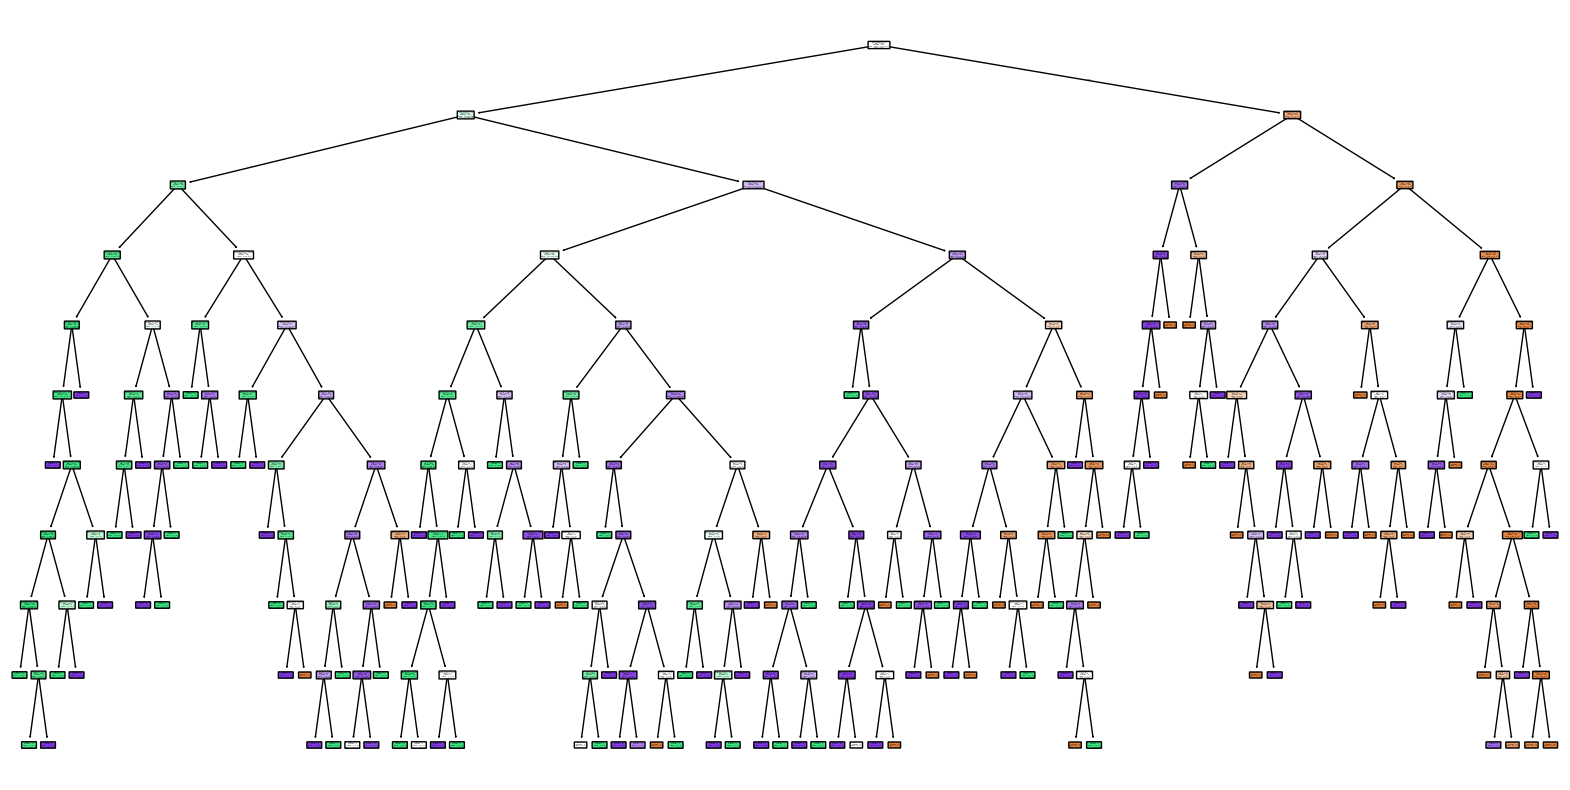

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report  # Añadir classification_report
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Lista de profundidades a probar
depths = [3, 5, 10]

# Diccionario para almacenar los resultados
results = {}

# Iterar sobre las profundidades
for depth in depths:
    print(f"\nEntrenando modelo con profundidad máxima = {depth}")
    
    # Crear y entrenar el modelo
    tree_clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree_clf.fit(X_train_cat, y_train_cat)
    
    # Predecir en el conjunto de prueba
    y_pred = tree_clf.predict(X_test_cat)
    
    # Calcular la precisión
    accuracy = accuracy_score(y_test_cat, y_pred)
    print(f'Precisión con profundidad {depth}: {accuracy}')
    
    # Guardar el resultado
    results[depth] = accuracy

    # Mostrar el reporte de clasificación para cada profundidad
    print(f'Reporte de clasificación para profundidad {depth}:')
    print(classification_report(y_test_cat, y_pred, target_names=tree_clf.classes_.astype(str)))

# Determinar cuál profundidad funcionó mejor
best_depth = max(results, key=results.get)
print(f"\nLa mejor profundidad es {best_depth} con una precisión de {results[best_depth]}")

# Crear y entrenar el mejor modelo
best_tree_clf = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
best_tree_clf.fit(X_train_cat, y_train_cat)

# Visualizar el árbol
plt.figure(figsize=(20, 10))
plot_tree(best_tree_clf, filled=True, feature_names=X.columns, class_names=best_tree_clf.classes_.astype(str), rounded=True)
plt.show()

## Resultado
El modelo con profundidad máxima = 10 funcionó mejor, ya que obtuvo la mayor precisión en el conjunto de prueba (80.14%). Esto indica que, en este caso, un árbol más complejo es capaz de capturar mejor los patrones en los datos y generalizar de manera efectiva.

## Paso 10

### Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Crear y entrenar el modelo de Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)  # 100 árboles, profundidad máxima = 10
rf_clf.fit(X_train_cat, y_train_cat)

# Predecir en el conjunto de prueba
y_pred_rf = rf_clf.predict(X_test_cat)

# Evaluar el modelo
accuracy_rf = accuracy_score(y_test_cat, y_pred_rf)
print(f'Precisión de Random Forest: {accuracy_rf}')

# Matriz de confusión
conf_matrix_rf = confusion_matrix(y_test_cat, y_pred_rf)
print('Matriz de confusión de Random Forest:')
print(conf_matrix_rf)

# Reporte de clasificación
print('Reporte de clasificación de Random Forest:')
print(classification_report(y_test_cat, y_pred_rf))

Precisión de Random Forest: 0.8253424657534246
Matriz de confusión de Random Forest:
[[83  0 12]
 [ 0 96 14]
 [ 7 18 62]]
Reporte de clasificación de Random Forest:
              precision    recall  f1-score   support

       Caras       0.92      0.87      0.90        95
  Económicas       0.84      0.87      0.86       110
 Intermedias       0.70      0.71      0.71        87

    accuracy                           0.83       292
   macro avg       0.82      0.82      0.82       292
weighted avg       0.83      0.83      0.83       292



### Comparación con el Árbol de decisión

Árbol de Decisión (profundidad = 10): 80.13%
Random Forest: 82.53%

**Conclusión**: Random Forest tiene una precisión general más alta que el Árbol de decisión

In [ ]:
Análisis Comparativo
1. Precisión (Accuracy):
- Árbol de Decisión: 80.13%
- Random Forest: 82.53%

2. Precisión (Precision):
Caras:
- Árbol de Decisión: 84%
- Random Forest: 92%

Económicas:
- Árbol de Decisión: 87%
- Random Forest: 84%

Intermedias:
- Árbol de Decisión: 69%
- Random Forest: 70%

**Conclusión**: Random Forest tiene una precisión más alta en todas las clases, especialmente en la clase "Caras".

3. Recall (Sensibilidad):
Caras:
- Árbol de Decisión: 82%
- Random Forest: 87%

Económicas:
- Árbol de Decisión: 82%
- Random Forest: 87%

Intermedias:
- Árbol de Decisión: 76%
- Random Forest: 71%

**Conclusión**: Random Forest tiene un recall ligeramente mejor en todas las clases, lo que significa que identifica correctamente más instancias de cada clase.

4. F1-Score:
Caras:
- Árbol de Decisión: 85%
- Random Forest: 90%

Económicas:
- Árbol de Decisión: 81%
- Random Forest: 86%

Intermedias:
- Árbol de Decisión: 68%
- Random Forest: 71%

**Conclusión**: Random Forest tiene un F1-score más alto en todas las clases, lo que indica un mejor equilibrio entre precisión y recall.

## Recomendación final

Usar Random Forest como modelo final. Dado que Random Forest tiene un mejor rendimiento en todas las métricas, es recomendable usarlo como modelo final para la clasificación de precios de viviendas

## Conclusión Final
Validación cruzada ayuda a evitar sobreajuste.
Si la precisión mejora con cv=5, el modelo es más estable.